<a href="https://colab.research.google.com/github/morprukop/RetailSalesAnalysis/blob/main/Final_book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages and Load Data

We are importing all packages necessary for our analysis

In [1]:
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import matplotlib.ticker as tick

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set Date Column to `datetime` for Both Files

#####Setting all three data sets to datetime for manipulating the date for analysis.


In [3]:
df_features = pd.read_csv('/content/drive/Shareddrives/Project_1/Data/store_features.csv')

#Converting date to datetime
df_features['Date'] = pd.to_datetime(df_features['Date'])
df_features.head(2)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True


In [4]:
df_sales = pd.read_csv('/content/drive/Shareddrives/Project_1/Data/sales.csv')

#Converting date to datetime
df_sales['Date'] = pd.to_datetime(df_sales['Date'])
df_sales.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True


In [5]:
df_stores = pd.read_csv('/content/drive/Shareddrives/Project_1/Data/stores.csv')
df_stores.head(2)

,Store,Type,Size
0,1,A,151315
1,2,A,202307


# Cleaning Data

#####Dropping Columns that are were unneeded in our analysis. Column 'IsHoliday' only provided true false values. 'Markdown' columns provided a great number of missing value in the data. 

In [6]:
#Dropping columns.
df_features = df_features.drop(['IsHoliday','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis = 1)
df_sales = df_sales.drop(['IsHoliday'], axis = 1)

#Creating new data set.
df_feat = df_features.dropna()

## Checking `dtypes` for both Files

In [7]:
#Checking data types 
df_feat.dtypes

Store                    int64
Date            datetime64[ns]
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

In [8]:
#Checking data types 
df_sales.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
dtype: object

## `Merging` All Files to Make one File to Analyze

#####To be able to analyse the store weekly sales we combined both data set 'df_sales' and 'df_feat' by columns 'Store' and 'Date'.

In [9]:
#Creating new data set by merging two
df = pd.merge(df_feat,df_sales, on=['Store','Date'])

df.head(2)

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,Dept,Weekly_Sales
0,1,2010-05-02,42.31,2.572,211.096358,8.106,1,24924.50
1,1,2010-05-02,42.31,2.572,211.096358,8.106,2,50605.27


In [10]:
df = pd.merge(df, df_stores, on= ['Store'])
df

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,Dept,Weekly_Sales,Type,Size
0,1,2010-05-02,42.31,2.572,211.096358,8.106,1,24924.50,A,151315
1,1,2010-05-02,42.31,2.572,211.096358,8.106,2,50605.27,A,151315
2,1,2010-05-02,42.31,2.572,211.096358,8.106,3,13740.12,A,151315
3,1,2010-05-02,42.31,2.572,211.096358,8.106,4,39954.04,A,151315
4,1,2010-05-02,42.31,2.572,211.096358,8.106,5,32229.38,A,151315
...,...,...,...,...,...,...,...,...,...,...
140674,45,2010-12-31,29.67,3.179,182.571448,8.724,93,2072.46,B,118221
140675,45,2010-12-31,29.67,3.179,182.571448,8.724,94,3966.80,B,118221
140676,45,2010-12-31,29.67,3.179,182.571448,8.724,95,43149.88,B,118221
140677,45,2010-12-31,29.67,3.179,182.571448,8.724,97,5881.22,B,118221


######Making sure our new data set included all the columns and the shape.

In [11]:
#Checking the shape
df.shape

(140679, 10)

In [12]:
#Checking the columns
df.columns

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'Dept', 'Weekly_Sales', 'Type', 'Size'],
      dtype='object')

## Seperating Date for In-depth Analysis

#####To be able to understand weekly sales throughout the year we seperated the dat into three columns, 'Day', 'Month', and 'Year'. We also created a column based on the days of the week.

In [13]:
#Creating new columns for day, month, year, and week day
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Week_day'] = df['Date'].dt.day_name()

#Holiday Recoding

## Making `dictionary` for Holidays

######A dictionary was created based on six of the top holidays throughout the year, Memorial Day, Halloween, Thanksgiving, Black Friday, Christmas, and New Years. This holidays were given the range of two weeks before their day to properly analyse the sales with the exception of Black Friday which only includes that one day.

In [14]:
# key range for holiday dictionary
# 0: Memorial Day, 1: Halloween, 2: Thanksgiving, 3: Black Friday, 4: Christmas, 5: NYE
#Monday, May 31

holiRange = [{'Holiday':'Memorial Day','Beg. Date':'2010-05-23', 'End Date': '2010-05-31'}
             ,{'Holiday':'Halloween','Beg. Date':'2010-10-17', 'End Date': '2010-10-31'}
             ,{'Holiday':'Thanksgiving','Beg. Date':'2010-11-11', 'End Date': '2010-11-25'}
             ,{'Holiday':'Black Friday','Beg. Date':'2010-11-26', 'End Date': '2010-11-26'}
             ,{'Holiday':'Christmas','Beg. Date':'2010-12-11', 'End Date': '2010-12-25'}
             ,{'Holiday':'New Years Eve','Beg. Date':'2010-12-17', 'End Date': '2010-12-31'}]


df_h = pd.DataFrame.from_records(holiRange)
#giving custom unique keys
df_h = pd.DataFrame.from_records(holiRange, index=['0', '1', '2','3','4','5'])
df_h = pd.DataFrame.from_dict(holiRange, orient='columns')

# Convert a list of dictionaries using json_normalize().
df_h = pd.json_normalize(holiRange)

df_h['Beg. Date'] = pd.to_datetime(df_h['Beg. Date'])
df_h['End Date'] = pd.to_datetime(df_h['End Date'])

## Code to Recode Holiday & IsHoliday

######The holidays from the previous dictionary are then put into a for loop that predicts whether they belong to one of the six holidays or to none based on the date. This then helps create a new 'Holiday' column for further analysis.

In [15]:
# IsHoliday = []
# Holiday = []
# for daye in df["Date"]:
#   givDay = daye.day
#   givMonth = daye.month

#   for i in range(0,6):
#     startDate = df_h.iloc[i]['Beg. Date'].day

#     startMonth = df_h.iloc[i]['Beg. Date'].month
#     diff = givDay - startDate

#     if givMonth == startMonth: 
#       if diff <= 14 and diff >= 0:
#         Holiday.append(df_h.iloc[i]['Holiday'])
#         IsHoliday.append(True)
#         break
#       elif i == 5:
#         Holiday.append('None')
#         IsHoliday.append(False)
#         break
#     elif i == 5: 
#       Holiday.append('None')
#       IsHoliday.append(False)
#       break
#     else: 
#       continue

# df['Holiday'] = Holiday
# df['IsHoliday'] = IsHoliday


# =============== importing the final cleaned data csv to avoid running for loop every time =======================
df = pd.read_csv('/content/drive/Shareddrives/Project_1/Data/cleaned_data.csv')

#Joining re-coded csv with the Store csv


######Grouping the 'Holiday' column based on its sum and average.

In [16]:
#group by holidays for weekly sum
holiSum = df.groupby('Holiday').sum()

holiMean = df.groupby('Holiday').mean()

##Analyzing Day, Month, and Year

###When combining the data sets only the year 2010 was included into the new data set.

In [17]:
df['Year'].unique()

array([2010])

In [18]:
df['Month'].unique()

array([ 5, 12,  2,  3,  9,  4,  7, 11,  6,  8, 10,  1])

In [19]:
df['Day'].unique()

array([ 2, 19, 26,  3,  4, 16, 23, 30,  5, 14, 21, 28,  6, 18, 25,  7,  8,
       13, 20, 27,  9, 17, 24, 10, 15, 22, 29, 11, 12, 31])

##Holiday and Month Weekly Sales

#####To be able to understand the factors on weekly sales, we looked into the effects based on the holiday sum and monthly sum. For Holiday the total weekly sales show to the highest count to be during Black Friday while the lowest in New Years. For Monthly weekly sales the lowest sales apear to be during the month of January and the highest during the month of December.

In [20]:
for holiday, data in df.groupby('Holiday'):
  print(f'The Holiday is = {holiday}')
  weekly = data['Weekly_Sales'].sum()
  print(f'Number of weekly sales is = {weekly}')

The Holiday is = Black Friday
Number of weekly sales is = 65821003.239999995
The Holiday is = Christmas
Number of weekly sales is = 188877016.27999997
The Holiday is = Halloween
Number of weekly sales is = 86669500.47
The Holiday is = Memorial Day
Number of weekly sales is = 47757502.56
The Holiday is = New Years Eve
Number of weekly sales is = 40432519.0
The Holiday is = None
Number of weekly sales is = 1814202994.6799996
The Holiday is = Thanksgiving
Number of weekly sales is = 45125584.18


In [21]:
for month, data in df.groupby('Month'):
  print(f'Month = {month}')
  week = data['Weekly_Sales'].sum()
  print(f'Number of weekly sales = {week}')

Month = 1
Number of weekly sales = 42239875.870000005
Month = 2
Number of weekly sales = 191586880.67000002
Month = 3
Number of weekly sales = 186226221.18
Month = 4
Number of weekly sales = 183811789.47
Month = 5
Number of weekly sales = 280611883.51
Month = 6
Number of weekly sales = 142436081.64
Month = 7
Number of weekly sales = 184266355.63
Month = 8
Number of weekly sales = 184538086.0
Month = 9
Number of weekly sales = 179704060.73000002
Month = 10
Number of weekly sales = 231120142.14999998
Month = 11
Number of weekly sales = 158773134.14
Month = 12
Number of weekly sales = 323571609.41999996


#Graph on Weekly Sales Factors


#####Importing modules

In [22]:
from dateutil.parser import parse 
from scipy.stats import linregress
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
import numpy as np

In [23]:
sns.set_palette("BrBG")

######Turning large tick values like 4500 (billions, millions, thousands)  into 4.5K and turns 4000 into 4K with no zero after the decimal. 
######This is done by creating a function to change each billion, million, ect., value into 4.5k or 4k. The value is then converted into a string value with no decimal.

In [24]:
def reformat_large_tick_values(tick_val, pos):

    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_formatsns.set(font_scale=1.4)

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format
#####################################https://dfrieds.com/data-visualizations/how-format-large-tick-values.html##################################

# Weekly Sales by Month

In [25]:
# fig, ax=plt.subplots(figsize=(15,7))
# ax = sns.regplot(x="Month", y="Weekly_Sales", data=df, x_jitter=.1)

#add ticks
#rename axes- make font the same size as the others
#add title

#####This graph shows the average weekly sales by month showing the analysis from before. Through the trend line, we can see the average sales increasing from January to December.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


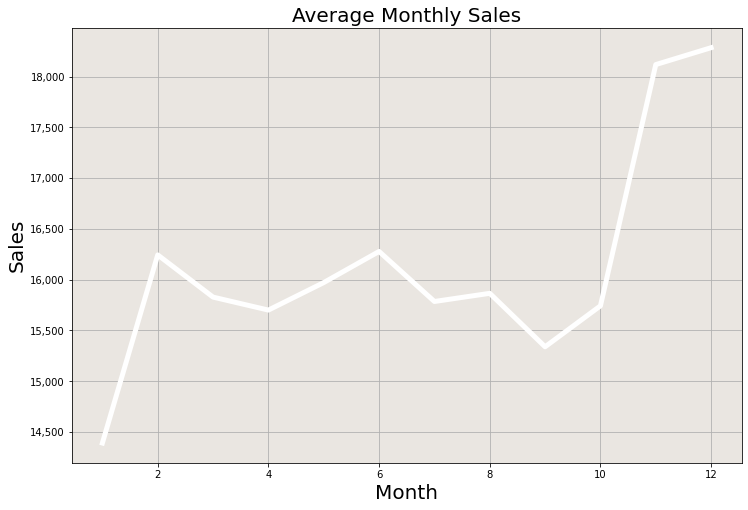

In [26]:
#Grouping the Month average then converting it into a list.
month_Sales = df.groupby('Month').mean()
month_Sales = month_Sales.reset_index()
monthList = month_Sales['Month']

#Turning the list into an array and reshaping.
X = np.array(monthList).reshape(-1,1)

#target data is array of shape (n,)
#Setting Weekly sales as y 
y = month_Sales['Weekly_Sales']

#Plotting weekly sales and month and decorating plot.
plt.figure(figsize=(12,8))

plt.title('Average Monthly Sales',fontsize=20)
plt.grid(True)
plt.xlabel('Month',fontsize=20)
plt.ylabel('Sales',fontsize=20)

ax = plt.axes()
ax.set_facecolor("#eae6e1")

plt.gca().get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


plt.plot(X, y, color='white', linewidth=5)
plt.show()

#Add ticks


#####This graph shows the sum of weekly sales by month showing the same trend as the previous graph. As the year progresses weekly sales increase with certain peaks in May, October and December.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


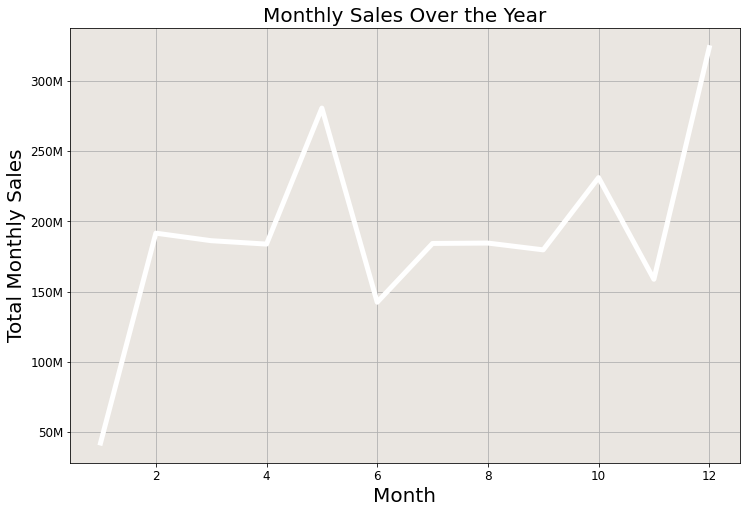

In [27]:
#Grouping the Month sum then converting it into a list.
month_Sales = df.groupby('Month').sum()
month_Sales = month_Sales.reset_index()
monthList = month_Sales['Month']

#Turning the list into an array and reshaping.
X = np.array(monthList).reshape(-1,1)

# # target data is array of shape (n,) 
#Setting Weekly sales as y 
y = month_Sales['Weekly_Sales']

#Plotting weekly sales and month and decorating plot.

plt.figure(figsize=(12,8))

plt.title('Monthly Sales Over the Year', fontsize=20)
plt.grid(True)
plt.xlabel('Month', fontsize = 20)
plt.ylabel('Total Monthly Sales', fontsize=20)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
ax = plt.axes()
ax.set_facecolor("#eae6e1")

ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

plt.plot(X, y, color='white', linewidth=5)

plt.show()



# Sum of Weekly Sales on Holidays

#####For Holiday analysis we excluded the None value for a better view of the weekly sales by holidays.

In [28]:
#Grouping Holiday with the exclusion of None value.
df.drop(df[df['Holiday'] == 'None'].index, inplace=True)

In [29]:
#Taking the sum of the grouped Holiday with the exclusion of None value.

holiSum = df.groupby('Holiday').sum()

#####The graph below shows the sum of weekly sales for each holiday with Christmas having the highest sum and New Years the lowest.

(array([0.00e+00, 2.50e+07, 5.00e+07, 7.50e+07, 1.00e+08, 1.25e+08,
        1.50e+08, 1.75e+08, 2.00e+08]),
 <a list of 9 Text major ticklabel objects>)

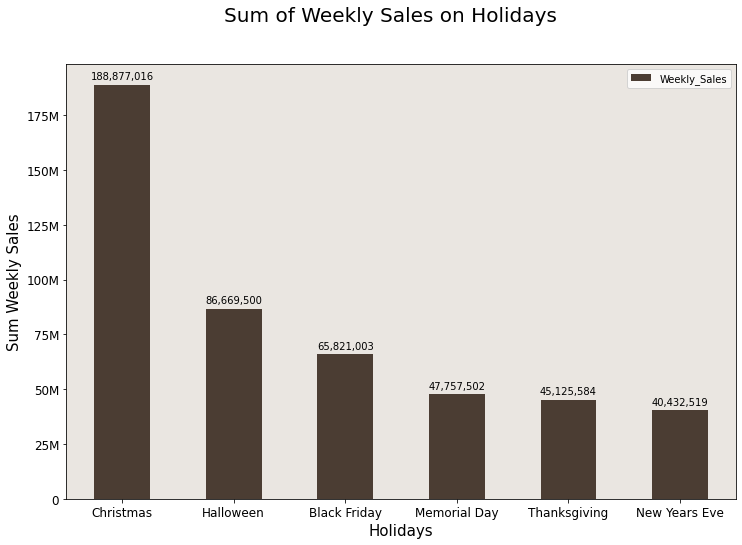

In [30]:
fig = holiSum[['Weekly_Sales']].sort_values(by='Weekly_Sales',ascending=False).plot.bar(y='Weekly_Sales', rot=0, figsize = [12,8],color='#4b3d33')


labels = holiSum['Weekly_Sales'].tolist()

labels.sort(reverse=True)

labels = ["{:,}".format(int(x)) for x in labels]
rects = fig.patches

for rect, label in zip(rects, labels): 
    height = rect.get_height()
    fig.text(
        rect.get_x() + rect.get_width() / 2, height + 1500000, label, ha="center", va="bottom"
    )

fig.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

plt.xticks(rotation=360, ha="center")
fig.set_facecolor('#eae6e1')

plt.xlabel('Holidays', fontsize=15)
plt.ylabel('Sum Weekly Sales', fontsize=15)
plt.suptitle('Sum of Weekly Sales on Holidays', fontsize=20)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 

#####The graph below shows the average of weekly sales for each holiday showing a different trend. We see that Black Friday has the highest average weekly sales and New Years the lowest.

(array([    0.,  5000., 10000., 15000., 20000., 25000.]),
 <a list of 6 Text major ticklabel objects>)

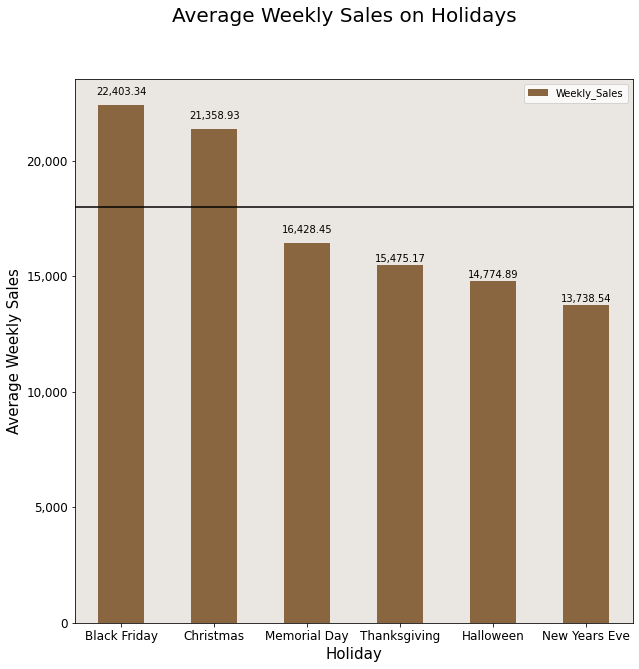

In [31]:
holiMean = df.groupby('Holiday').mean()

fig = holiMean[['Weekly_Sales']].sort_values(by='Weekly_Sales',ascending=False).plot.bar(y='Weekly_Sales',color='#89663f', rot=0, figsize = [10,10])

mean = df['Weekly_Sales'].mean()
fig.axhline(mean,color = 'black')

labels = holiMean['Weekly_Sales'].tolist()

labels.sort(reverse=True)

rects = fig.patches
for rect, label in zip(rects, labels):
  height = rect.get_height()
  if float(label) < 15500:
    fig.text(
        rect.get_x() + rect.get_width() / 2, height+50, "{:,}".format(round(label,2)), ha="center", va="bottom"
    )
  else:
    fig.text(
        rect.get_x() + rect.get_width() / 2, height+350, "{:,}".format(round(label,2)), ha="center", va="bottom"
    )

fig.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
fig.set_facecolor('#eae6e1')

plt.figsize=(12,16)
plt.xlabel('Holiday', fontsize=15)
plt.ylabel('Average Weekly Sales', fontsize=15)
plt.suptitle('Average Weekly Sales on Holidays', fontsize=20)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 

#Temperature on Weekly Sales

#####The plot below shows the analysis on the effects of tempeture on weekly sales ranging from 0 to 95 degrees. Temperature is then binned by 5 and grouped by average.

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000.]),
 <a list of 7 Text major ticklabel objects>)

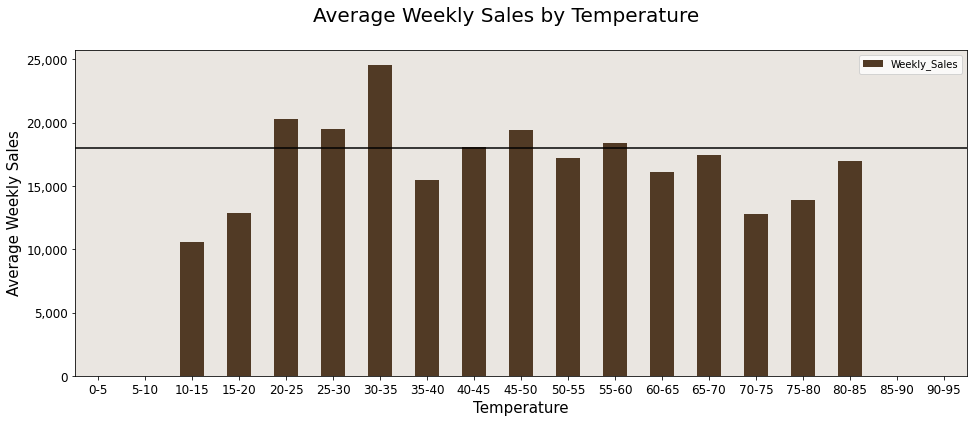

In [32]:
#Temperature binned by 5 & Average Weekly Sales

df['bin'] = pd.cut(df['Temperature'], bins=range(0,100,5), labels=[f'{l}-{l+5}' for l in range(0,91,5)])

#Grouped bin by average
mean_temp = df.groupby('bin').mean()

fig = mean_temp.plot(kind='bar',y='Weekly_Sales',figsize=(16,6), color='#513a25')

#Taking the average of the weekly sales
mean = df['Weekly_Sales'].mean()

#GRaph plotting and decorating
fig.axhline(mean,color = 'black')

fig.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=360, ha="center")
fig.set_facecolor('#eae6e1')


plt.figsize=(12,8)
plt.xlabel('Temperature', fontsize=15)
plt.ylabel('Average Weekly Sales', fontsize=15)
plt.suptitle('Average Weekly Sales by Temperature', fontsize=20)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 

#Size of Store 

#######Analysis was done based on the size of a store and its effect on the average weekly sales. This was done by grouping the size by average on weekly sales.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


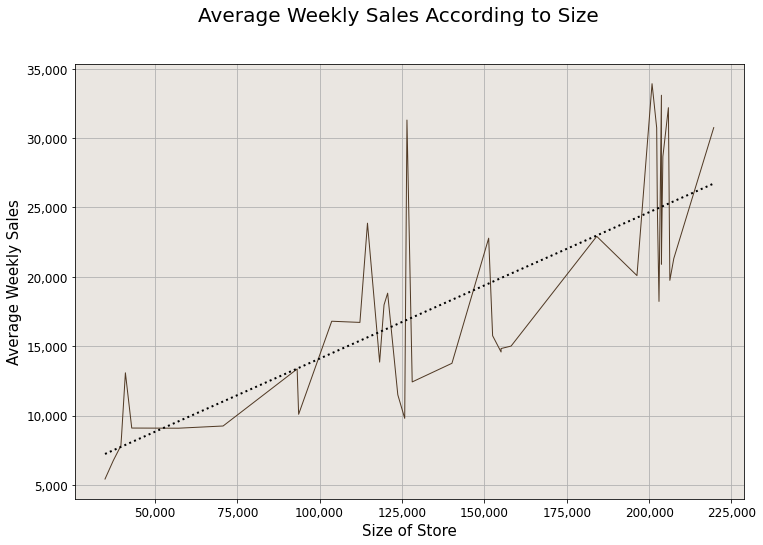

In [33]:
#Size of store x & avg weekly sales y
sizeMean = df.groupby('Size').mean()
sizeMean = sizeMean.reset_index()
sizeList = sizeMean['Size']

# LinearRegression will expect an array of shape (n, 1) 
# for the "Training data"
X = np.array(sizeList).reshape(-1,1)

# target data is array of shape (n,) 
y = sizeMean['Weekly_Sales']

#Plotting and decorating
plt.figure(figsize=(12,8))

plt.xlabel('Size of Store', fontsize=15)
plt.ylabel('Average Weekly Sales', fontsize=15)
plt.suptitle('Average Weekly Sales According to Size', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 

ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax = plt.axes()
ax.set_facecolor("#eae6e1")

#adding tick marks
plt.gca().get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.gca().get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#Including a linear regression line

trend = linear_model.LinearRegression()
model = trend.fit(X, y)
scatter_y_pred = trend.predict(X)
plt.plot(X,y, color = '#513a25', linewidth=1)
plt.plot(X, scatter_y_pred, color='black', linewidth=2, linestyle=':')
plt.show()

# Correlation of Weekly Sales and Factors

#####Based on the analysis done on deparment store size, temperature, and holidays on weekly sales, we further took the correlation for a better understanding. Correlation shows that size has the most effect on weekly sales, but the correlation is too small to have a big affect on weekly sales.

In [34]:
cor = df.corr().loc[['Size','Temperature','IsHoliday', 'Month'],['Weekly_Sales']]**2
cor

,Weekly_Sales
Size,0.053185
Temperature,0.002041
IsHoliday,NaN
Month,0.001679


# Not Being Used

#####Data we saw had no correlation on weekly sales included CPI and Unemployment.

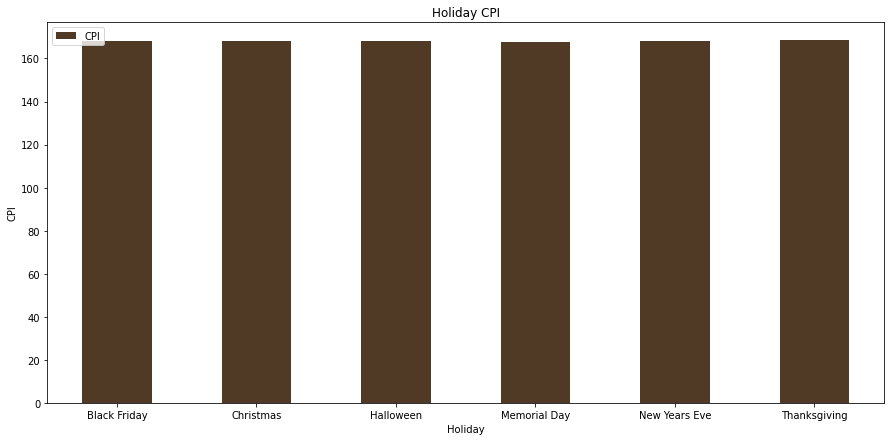

In [35]:
#This isn't being used ###### HIDDEN SLIDE- delete after on presentation
fig, ax = plt.subplots(figsize=(15,7))
df.groupby('Holiday')['CPI'].mean().plot(kind='bar',legend=True, color ='#513a25')
ax.legend(loc='upper left')
ax.set_title('Holiday CPI')
# ax.grid(True)
plt.xlabel('Holiday')
plt.ylabel('CPI')
plt.xticks(rotation=360, ha="center")
plt.show()

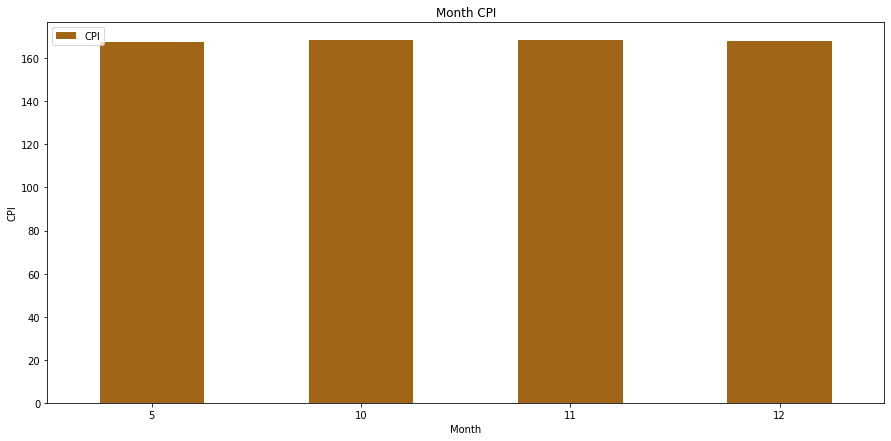

In [36]:
#This isn't being used ###### HIDDEN SLIDE- delete after on presentation
fig, ax = plt.subplots(figsize=(15,7))
df.groupby('Month')['CPI'].mean().plot(kind='bar')
ax.legend(loc='upper left')
ax.set_title('Month CPI')
# ax.grid(True)
plt.xlabel('Month')
plt.ylabel('CPI')
plt.xticks(rotation=360, ha="center")
plt.show()